In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

# Overview

(this talk draws heavily on rdeits/DetroitTechWatch2020.jl)

* What is Julia?
* Language basics
* Julia is fast!
* Get more science done with Julia

# What is Julia?

* We want the speed of C.
* We want to write in the obvious, familiar mathematical notation.
* We want a language usable for general programming like Python
* We want to make it easy to do statistics and linear algebra.
* We want it interactive and we want it compiled.


(Did we mention it should be as fast as C?)

# The Basics

Arithmetic

In [2]:
2 + 3

5

Strings:

In [3]:
# Strings
print("hello DESC")

hello DESC

Arrays:

In [4]:
A = [1, 2, 3, 4]

4-element Vector{Int64}:
 1
 2
 3
 4

# Functions

In [5]:
function square(x)
    return x * x 
end

square (generic function with 1 method)

In [6]:
square(2)

4

In [7]:
square("hello")

"hellohello"

# Why is Julia fast?

Julia will compile native-machine code into memory, right when it is needed, also known as Just-In-Time (JIT) compilation.

In [8]:
square(2)

4

In [9]:
@code_native square(2)

	.text
; ┌ @ In[5]:1 within `square'
	movq	%rdi, %rax
; │ @ In[5]:2 within `square'
; │┌ @ int.jl:88 within `*'
	imulq	%rdi, %rax
; │└
	retq
	nopl	(%rax,%rax)
; └


These are x86 *hardware instructions*. This function has been compiled into the same form that a C or Fortran function would be.

In [10]:
A = [9.0  1.5  2.0;
     0.5  8.0  1.0;
     1.0  2.5  6.0]

square(A)

3×3 Matrix{Float64}:
 83.75  30.5   31.5
  9.5   67.25  15.0
 16.25  36.5   40.5

# Loops 

To perform elementwise operations on vectors, we could write a simple loop.

In [11]:
function elementwise_square_vector(v)
    # make an array of the same size
    result = similar(v) 
    
    # loop over and square each element
    for i in 1:length(v)
        result[i] = v[i]^2
    end
    
    return result
end

elementwise_square_vector([1, 2, 3])

3-element Vector{Int64}:
 1
 4
 9

Julia has a special "dot" syntax (called broadcasting), which performs elementwise operations.

In [12]:
x = [1,2,3]

x .^ 2

3-element Vector{Int64}:
 1
 4
 9

# Packages Management

Julia has an excellent package manager. To access the methods of a package, just write `using`. 

In [13]:
using LinearAlgebra

A = [9.0  1.5  2.0;
     0.5  8.0  1.0;
     1.0  2.5  6.0]

det(A)

393.0

# Python Interoperation

You can easily call Python from Julia, and similarly call Julia from Python. There is also a nicer wrapping of matplotlib called `PyPlot` which lets you use the plotting syntax you're used to.

In [14]:
using PyPlot; PyPlot.svg(true);  # I develop on a hidpi screen

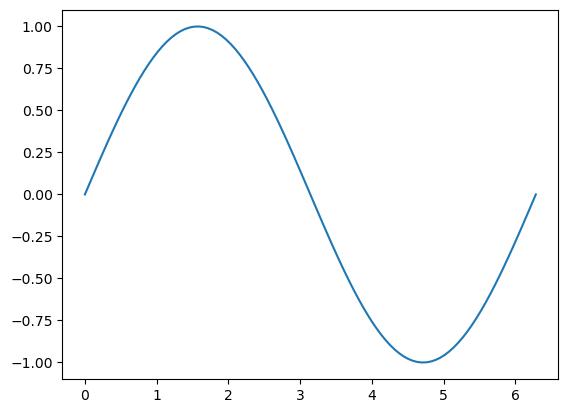

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7fce18df0280>

In [15]:
using PyPlot
x = LinRange(0, 2π, 100)  
plt.plot(x, sin.(x))

For other Python packages, you can use the `PyCall` package.

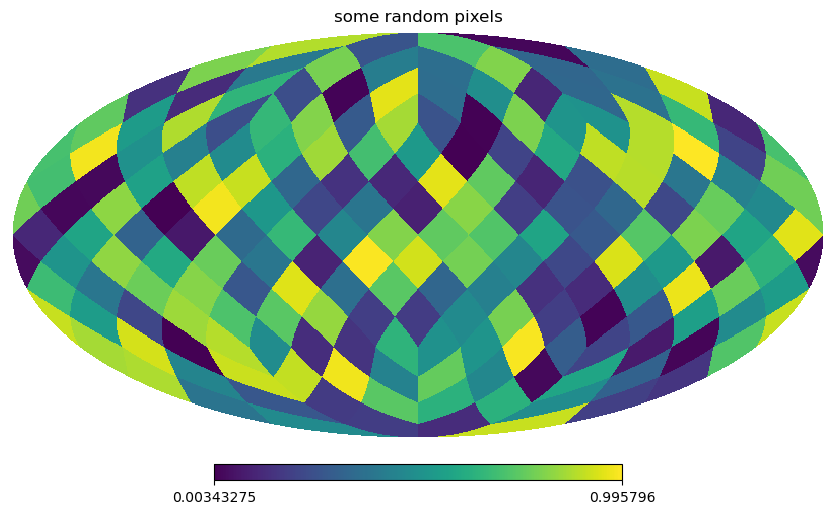

In [16]:
using PyCall
hp = pyimport("healpy")

hp.mollview(rand(192), title="some random pixels")

# Composability

Julia is remarkably composable, because you can define the methods that operate on a type without owning the type.